# Semantic segmentation with SegFormer and Hugging Face Transformers

**Adapted from:** https://keras.io/examples/vision/segformer/<br>
**Description:** Fine-tuning a SegFormer model variant for semantic segmentation.

## Introduction

In this example, we show how to fine-tune a SegFormer model variant to do
semantic segmentation on a custom dataset. Semantic segmentation is the task of
assigning a category to each and every pixel of an image. SegFormer was proposed in
[SegFormer: Simple and Efficient Design for Semantic Segmentation with Transformers](https://arxiv.org/abs/2105.15203).
SegFormer uses a hierarchical Transformer architecture (called "Mix Transformer") as
its encoder and a lightweight decoder for segmentation. As a result, it yields
state-of-the-art performance on semantic segmentation while being more efficient than
existing models. For more details, check out the original paper.

![segformer-arch](https://i.imgur.com/BsrVwYe.png)

We leverage
[Hugging Face Transformers](https://github.com/huggingface/transformers)
to load a pretrained SegFormer checkpoint and fine-tune it on a custom dataset.

**Note:** this example reuses code from the following sources:

* [Official tutorial on segmentation from the TensorFlow team](https://www.tensorflow.org/tutorials/images/segmentation)
* [Hugging Face Task guide on segmentation](https://huggingface.co/docs/transformers/main/en/tasks/semantic_segmentation)

To run this example, we need to install the `transformers` library:

In [ ]:
!!pip install transformers -q
# install required libraries
!pip install -q rasterio
!pip install -q geopandas
!pip install -q radiant_mlhub # for dataset access, see: https://mlhub.earth/
!pip install tensorflow_io
!pip install tiffile

In [189]:
import os, glob, functools, fnmatch, io, shutil, tarfile, json
from zipfile import ZipFile
from itertools import product
from pathlib import Path
import urllib.request
from PIL import Image
import numpy as np
from radiant_mlhub import Dataset, client, get_session, Collection
import pandas as pd
from google.colab import drive
import tiffile as tiff
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import backend
import rasterio
from skimage.transform import resize
from transformers import TFSegformerForSemanticSegmentation

In [ ]:
# Mount google drive.
drive.mount('/content/gdrive')

In [191]:
# set your root directory and tiled data folders
if 'google.colab' in str(get_ipython()):
    # mount google drive
    drive.mount('/content/gdrive')
    root_dir = '/content/gdrive/My Drive/tf-eo-devseed-2/'
    workshop_dir = '/content/gdrive/My Drive/tf-eo-devseed-workshop-2'
    dirs = [root_dir, workshop_dir]
    for d in dirs:
        if not os.path.exists(d):
            os.makedirs(d)
    print('Running on Colab')
else:
    root_dir = os.path.abspath("./data/tf-eo-devseed-2")
    workshop_dir = os.path.abspath('./tf-eo-devseed-workshop-2')
    print(f'Not running on Colab, data needs to be downloaded locally at {os.path.abspath(root_dir)}')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Running on Colab


In [193]:
%cd $root_dir

/content/gdrive/My Drive/tf-eo-devseed-2


## Load the data

We use the [LandCoverNet South America](https://mlhub.earth/data/ref_landcovernet_sa_v1) dataset for
this example.

In [ ]:
# configure Radiant Earth MLHub access
!mlhub configure

In [ ]:
ds = Dataset.fetch('ref_landcovernet_sa_v1')
for c in ds.collections:
    print(c.id)


ref_landcovernet_sa_v1_source_sentinel_2
ref_landcovernet_sa_v1_source_sentinel_1
ref_landcovernet_sa_v1_source_landsat_8
ref_landcovernet_sa_v1_labels


In [ ]:
collections = [
    'ref_landcovernet_sa_v1_source_landsat_8',
    'ref_landcovernet_sa_v1_labels'
]

def download(collection_id):
    print(f'Downloading {collection_id}...')
    collection = Collection.fetch(collection_id)
    path = collection.download('.')
    tar = tarfile.open(path, "r:gz")
    tar.extractall()
    tar.close()
    os.remove(path)

def resolve_path(base, path):
    return Path(os.path.join(base, path)).resolve()

def load_df(collection_id):
    collection = json.load(open(f'{collection_id}/collection.json', 'r'))
    rows = []
    item_links = []
    for link in collection['links']:
        if link['rel'] != 'item':
            continue
        item_links.append(link['href'])
    for item_link in item_links:
        item_path = f'{collection_id}/{item_link}'
        current_path = os.path.dirname(item_path)
        item = json.load(open(item_path, 'r'))
        tile_id = item['id'].split('_')[-1]
        for asset_key, asset in item['assets'].items():
            rows.append([
                tile_id,
                None,
                None,
                asset_key,
                str(resolve_path(current_path, asset['href']))
            ])

        for link in item['links']:
            if link['rel'] != 'source':
                continue
            link_path = resolve_path(current_path, link['href'])
            source_path = os.path.dirname(link_path)
            try:
                source_item = json.load(open(link_path, 'r'))
            except FileNotFoundError:
                continue
            datetime = source_item['properties']['datetime']
            satellite_platform = source_item['collection'].split('_')[-1]
            for asset_key, asset in source_item['assets'].items():
                rows.append([
                    tile_id,
                    datetime,
                    satellite_platform,
                    asset_key,
                    str(resolve_path(source_path, asset['href']))
                ])
    return pd.DataFrame(rows, columns=['tile_id', 'datetime', 'satellite_platform', 'asset', 'file_path'])

#for c in collections:
    #download(c)

train_df = load_df('ref_landcovernet_sa_v1_labels')
#test_df = load_df('ref_landcovernet_sa_v1_labels')

  0%|          | 0/9.6 [00:00<?, ?M/s]

### Pre-process the data for SegFormer

For preparing the datasets for training and evaluation, we:

* Normalize the images with the mean and standard deviation used during pre-training
SegFormer.
* Subtract 1 from the segmentation masks so that the pixel values start from 0.
* Resize the images.
* Transpose the images such that they are in `"channels_first"` format. This is to make
them compatible with the SegFormer model from Hugging Face Transformers.

In [207]:
def compile_dataset(impath, dataset_split):
  r = rasterio.open(f"{impath}/B04.tif").read().transpose(1,2,0)
  g = rasterio.open(f"{impath}/B03.tif").read().transpose(1,2,0)
  b = rasterio.open(f"{impath}/B02.tif").read().transpose(1,2,0)
  rgb = (np.dstack((r,g,b)) * 255.999) .astype(np.uint8)
  resized_rgb_image = resize(rgb, (image_size, image_size), order=0, preserve_range=True, anti_aliasing=False).astype('uint8')
  rgb_im = Image.fromarray(resized_rgb_image)
  im_id = impath.split('/')[1]
  rgb_im.save(f"ref_landcovernet_sa_v1_rgb_images_{dataset_split}/{im_id}.png", "PNG")
  maskpath = impath.replace("source_landsat_8", "labels")
  maskpath = maskpath[:-9]
  mask_file = f"{maskpath}/labels.tif"
  mask_image = rasterio.open(f"{mask_file}").read().transpose(1,2,0)
  mask_image = mask_image[:, :, 0]
  #mask_image = np.expand_dims(mask_image, axis=2)
  #print(mask_image.shape)
  resized_mask_image = resize(mask_image, (image_size, image_size), order=0, preserve_range=True, anti_aliasing=False).astype('uint8')
  #print(np.unique(resized_mask_image))
  mask_image = Image.fromarray(resized_mask_image)
  mask_image.save(f"ref_landcovernet_sa_v1_label_images_{dataset_split}/{im_id}.png", "PNG")


In [201]:
p = Path('ref_landcovernet_sa_v1_source_landsat_8/')

# All subdirectories in the current directory, not recursive.
subdirs = [f for f in p.iterdir() if f.is_dir()]

In [202]:
len(subdirs)

34229

### Partition the data
Because we have 34229 data points to work with, let's just practice on a subset.
*   1000 samples for training to start
*   200 for validation
*   1000 for testing

In [ ]:
i = 0
for s in subdirs[0:1000]: # Swap for val and test accordingly, TODO: create funtion
  #print(str(s))
  compile_dataset(str(s), "train") # Swap for val and test accordingly, TODO: create funtion
  i = i+1

### Build the dataloader for each partition

We now use the above utilities to prepare dataset objects including
`prefetch()` for performance. Change the `batch_size` to match the size of the GPU memory
on the GPU that you're using for training.

In [222]:
AUTO = tf.data.AUTOTUNE
BATCH_SIZE = 4
image_size = 512
mean = tf.constant([0.485, 0.456, 0.406])
std = tf.constant([0.229, 0.224, 0.225])

def normalize(input_image, input_mask):
    input_image = tf.image.convert_image_dtype(input_image, tf.float32)
    input_image = (input_image - mean) / tf.maximum(std, backend.epsilon())
    #input_mask -= 1
    print("input_mask unique: ", tf.unique(tf.reshape(sample_mask,[-1])))
    return input_image, input_mask


def load(image_file, mask_file):
  image = tf.io.read_file(image_file)
  image = tf.io.decode_png(image)

  mask = tf.io.read_file(mask_file)
  mask = tf.io.decode_png(mask)

  input_image = tf.cast(image, tf.float32)
  mask_image = mask #tf.squeeze(mask)
  mask_image = tf.cast(mask_image, tf.float32)

  input_image = tf.image.resize(input_image, (image_size, image_size))
  input_mask = tf.image.resize(
        mask_image,
        (image_size, image_size),
        method="nearest",
        antialias=False,
  )


  input_image, input_mask = normalize(input_image, input_mask)
  input_image = tf.transpose(input_image, (2, 0, 1))
  reshaped_input_mask = tf.reshape(input_mask, (512, 512, 1))
  return {"pixel_values": input_image, "labels": tf.squeeze(reshaped_input_mask)}


train_images = glob.glob('ref_landcovernet_sa_v1_rgb_images_train//*.*')
train_labels = glob.glob('ref_landcovernet_sa_v1_label_images_train//*.*')
train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))

val_images = glob.glob('ref_landcovernet_sa_v1_rgb_images_val//*.*')
val_labels = glob.glob('ref_landcovernet_sa_v1_label_images_val//*.*')
val_ds = tf.data.Dataset.from_tensor_slices((val_images, val_labels))

test_images = glob.glob('ref_landcovernet_sa_v1_rgb_images_test//*.*')
test_labels = glob.glob('ref_landcovernet_sa_v1_label_images_test//*.*')
test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

train_ds = (
    train_ds
    .map(load, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
    )


val_ds = (
    val_ds
    .map(load, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
    )


test_ds = (
    test_ds
    .map(load, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
    )

input_mask unique:  Unique(y=<tf.Tensor 'Unique:0' shape=(None,) dtype=uint8>, idx=<tf.Tensor 'Unique:1' shape=(262144,) dtype=int32>)
input_mask unique:  Unique(y=<tf.Tensor 'Unique:0' shape=(None,) dtype=uint8>, idx=<tf.Tensor 'Unique:1' shape=(262144,) dtype=int32>)
input_mask unique:  Unique(y=<tf.Tensor 'Unique:0' shape=(None,) dtype=uint8>, idx=<tf.Tensor 'Unique:1' shape=(262144,) dtype=int32>)


We can check the shapes of the input images and their segmentation maps:

In [223]:
print(train_ds.element_spec)

{'pixel_values': TensorSpec(shape=(None, 3, 512, 512), dtype=tf.float32, name=None), 'labels': TensorSpec(shape=(None, 512, 512), dtype=tf.float32, name=None)}


## Visualize dataset

(3, 512, 512) (512, 512)
(512, 512, 3) (512, 512, 1) Unique(y=<tf.Tensor: shape=(3,), dtype=float32, numpy=array([7., 5., 6.], dtype=float32)>, idx=<tf.Tensor: shape=(262144,), dtype=int32, numpy=array([0, 0, 0, ..., 1, 1, 1], dtype=int32)>)


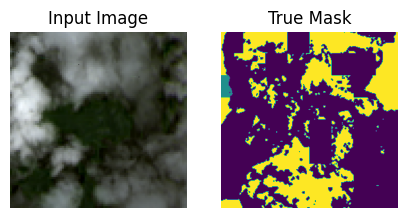

(3, 512, 512) (512, 512)
(512, 512, 3) (512, 512, 1) Unique(y=<tf.Tensor: shape=(2,), dtype=float32, numpy=array([7., 3.], dtype=float32)>, idx=<tf.Tensor: shape=(262144,), dtype=int32, numpy=array([0, 0, 0, ..., 0, 0, 0], dtype=int32)>)


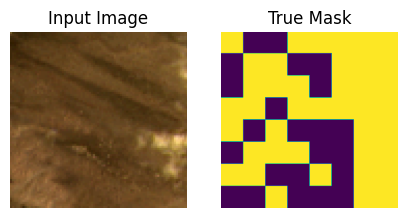

(3, 512, 512) (512, 512)
(512, 512, 3) (512, 512, 1) Unique(y=<tf.Tensor: shape=(4,), dtype=float32, numpy=array([7., 5., 6., 2.], dtype=float32)>, idx=<tf.Tensor: shape=(262144,), dtype=int32, numpy=array([0, 0, 0, ..., 0, 0, 0], dtype=int32)>)


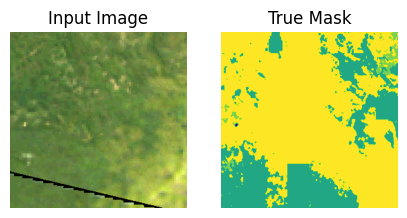

(3, 512, 512) (512, 512)
(512, 512, 3) (512, 512, 1) Unique(y=<tf.Tensor: shape=(3,), dtype=float32, numpy=array([7., 2., 6.], dtype=float32)>, idx=<tf.Tensor: shape=(262144,), dtype=int32, numpy=array([0, 0, 0, ..., 0, 0, 0], dtype=int32)>)


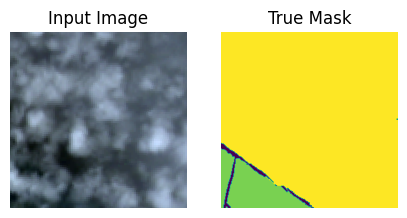

(3, 512, 512) (512, 512)
(512, 512, 3) (512, 512, 1) Unique(y=<tf.Tensor: shape=(4,), dtype=float32, numpy=array([7., 2., 5., 3.], dtype=float32)>, idx=<tf.Tensor: shape=(262144,), dtype=int32, numpy=array([0, 0, 0, ..., 0, 0, 0], dtype=int32)>)


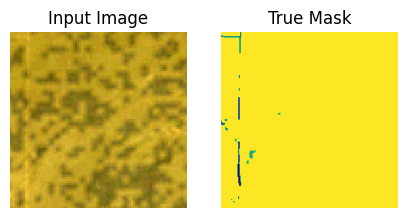

(3, 512, 512) (512, 512)
(512, 512, 3) (512, 512, 1) Unique(y=<tf.Tensor: shape=(2,), dtype=float32, numpy=array([5., 7.], dtype=float32)>, idx=<tf.Tensor: shape=(262144,), dtype=int32, numpy=array([0, 0, 0, ..., 0, 0, 0], dtype=int32)>)


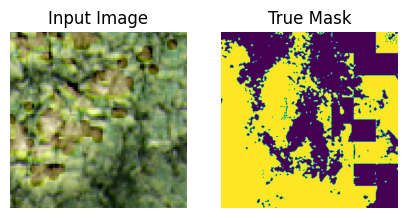

(3, 512, 512) (512, 512)
(512, 512, 3) (512, 512, 1) Unique(y=<tf.Tensor: shape=(5,), dtype=float32, numpy=array([5., 7., 6., 2., 1.], dtype=float32)>, idx=<tf.Tensor: shape=(262144,), dtype=int32, numpy=array([0, 0, 0, ..., 0, 0, 0], dtype=int32)>)


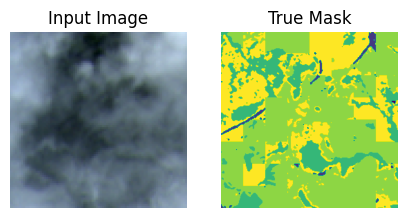

(3, 512, 512) (512, 512)
(512, 512, 3) (512, 512, 1) Unique(y=<tf.Tensor: shape=(4,), dtype=float32, numpy=array([5., 7., 1., 6.], dtype=float32)>, idx=<tf.Tensor: shape=(262144,), dtype=int32, numpy=array([0, 0, 0, ..., 0, 0, 0], dtype=int32)>)


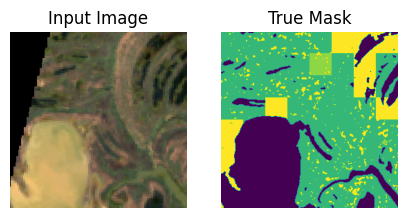

(3, 512, 512) (512, 512)
(512, 512, 3) (512, 512, 1) Unique(y=<tf.Tensor: shape=(5,), dtype=float32, numpy=array([5., 7., 6., 2., 1.], dtype=float32)>, idx=<tf.Tensor: shape=(262144,), dtype=int32, numpy=array([0, 0, 0, ..., 0, 0, 0], dtype=int32)>)


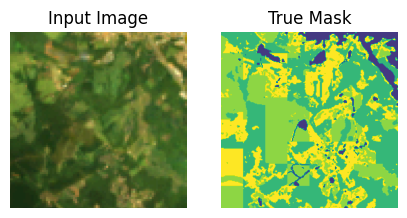

(3, 512, 512) (512, 512)
(512, 512, 3) (512, 512, 1) Unique(y=<tf.Tensor: shape=(3,), dtype=float32, numpy=array([7., 6., 5.], dtype=float32)>, idx=<tf.Tensor: shape=(262144,), dtype=int32, numpy=array([0, 0, 0, ..., 2, 2, 2], dtype=int32)>)


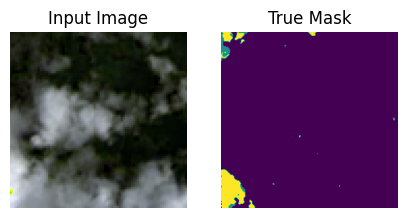

In [224]:
import matplotlib.pyplot as plt


def display(display_list):
    plt.figure(figsize=(5, 5))

    title = ["Input Image", "True Mask", "Predicted Mask"]

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i + 1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        plt.axis("off")
    plt.show()


for samples in train_ds.take(10):
    sample_image, sample_mask = samples["pixel_values"][0], samples["labels"][0]
    print(sample_image.shape, sample_mask.shape)
    sample_image = tf.transpose(sample_image, (1, 2, 0))
    sample_mask = tf.expand_dims(sample_mask, -1)
    print(sample_image.shape, sample_mask.shape, tf.unique(tf.reshape(sample_mask,[-1])))
    display([sample_image, sample_mask])

## Load a pretrained SegFormer checkpoint

We now load a pretrained SegFormer model variant from Hugging Face Transformers. The
SegFormer model comes in different variants dubbed as **MiT-B0** to **MiT-B5**. You can
find these checkpoints
[here](https://huggingface.co/models?pipeline_tag=image-segmentation&sort=downloads&search=segformer).
We load the smallest variant Mix-B0, which produces a good trade-off
between inference efficiency and predictive performance.

In [234]:
model_checkpoint = "nvidia/mit-b0"

# Classes below derived from https://radiantearth.blob.core.windows.net/mlhub/landcovernet_sa/Documentation.pdf

id2label = {0: "Background", 1: "water", 2: "artificial_bare_ground", 3: "natural_bare_ground", 4: "permanent_snow_ice", 5: "woody_vegetation", 6: "cultivated_vegetation", 7: "semi_natural_vegetation"}
label2id = {label: id for id, label in id2label.items()}
num_labels = len(id2label)
model = TFSegformerForSemanticSegmentation.from_pretrained(
    model_checkpoint,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)

Some layers from the model checkpoint at nvidia/mit-b0 were not used when initializing TFSegformerForSemanticSegmentation: ['classifier']
- This IS expected if you are initializing TFSegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFSegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFSegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


The warning is telling us that we're throwing away some weights and newly initializing
some others. Don't panic! This is absolutely normal. Since we're using a custom dataset
which has a different set of semantic class labels than the pre-training dataset,
[`TFSegformerForSemanticSegmentation`](https://huggingface.co/docs/transformers/model_doc/segformer#transformers.TFSegformerForSemanticSegmentation)
is initializing a new decoder head.

We can now initialize an optimizer and compile the model with it.

## Compile the model

In [235]:
lr = 0.001 #0.00006
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=optimizer)

Notice that we are not using any loss function for compiling the model. This is because
the forward pass of the model
[implements](https://github.com/huggingface/transformers/blob/820c46a707ddd033975bc3b0549eea200e64c7da/src/transformers/models/segformer/modeling_tf_segformer.py#L873)
the loss computation part when we provide labels alongside the input images. After
computing the loss, the model returned a structured `dataclass` object which is
then used to guide the training process.

With the compiled model, we can proceed and call `fit()` on it to begin the fine-tuning
process!

## Prediction callback to monitor training progress

It helps us to visualize some sample predictions when the model is being fine-tuned,
thereby helping us to monitor the progress of the model. This callback is inspired from
[this tutorial](https://www.tensorflow.org/tutorials/images/segmentation).

In [236]:
from IPython.display import clear_output


def create_mask(pred_mask):
    pred_mask = tf.math.argmax(pred_mask, axis=1)
    pred_mask = tf.expand_dims(pred_mask, -1)
    return pred_mask[0]


def show_predictions(dataset=None, num=1):
    if dataset:
        for sample in dataset.take(num):
            images, masks = sample["pixel_values"], sample["labels"]
            masks = tf.expand_dims(masks, -1)
            pred_masks = model.predict(images).logits
            images = tf.transpose(images, (0, 2, 3, 1))
            display([images[0], masks[0], create_mask(pred_masks)])
    else:
        display(
            [
                sample_image,
                sample_mask,
                create_mask(model.predict(tf.expand_dims(sample_image, 0))),
            ]
        )


class DisplayCallback(tf.keras.callbacks.Callback):
    def __init__(self, dataset, **kwargs):
        super().__init__(**kwargs)
        self.dataset = dataset

    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions(self.dataset)
        print("\nSample Prediction after epoch {}\n".format(epoch + 1))


## Train model

1/1 [==============================] - 0s 108ms/step


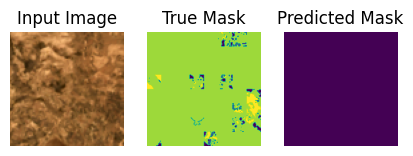


Sample Prediction after epoch 10

250/250 [==============================] - 119s 476ms/step - loss: 1.3257 - val_loss: 1.3368


In [237]:
# Increase the number of epochs if the results are not of expected quality.
epochs = 10

history = model.fit(
    train_ds,
    validation_data=test_ds,
    callbacks=[DisplayCallback(val_ds)],
    epochs=epochs,
)

## Inference

We perform inference on a few samples from the test set.

1/1 [==============================] - 0s 217ms/step


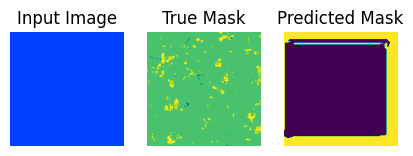

1/1 [==============================] - 0s 174ms/step


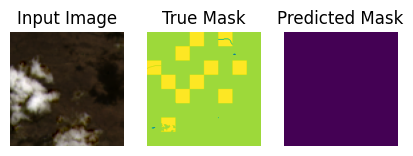

1/1 [==============================] - 0s 305ms/step


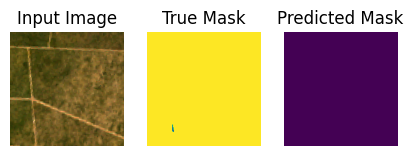

1/1 [==============================] - 0s 116ms/step


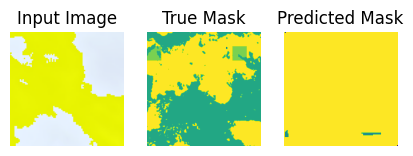

1/1 [==============================] - 0s 122ms/step


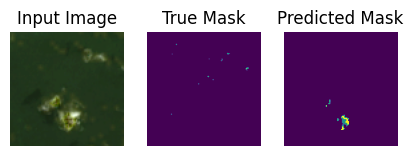

1/1 [==============================] - 0s 105ms/step


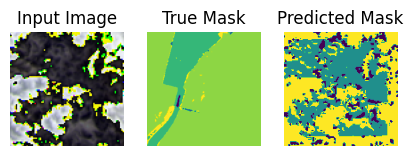

1/1 [==============================] - 0s 108ms/step


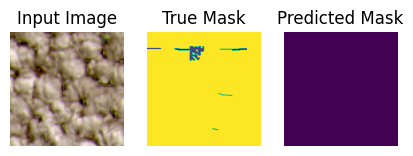

1/1 [==============================] - 0s 127ms/step


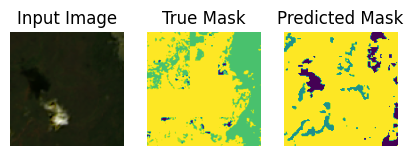

1/1 [==============================] - 0s 123ms/step


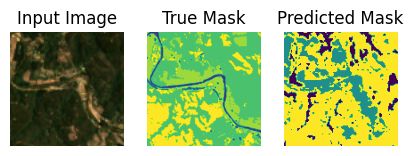

1/1 [==============================] - 0s 113ms/step


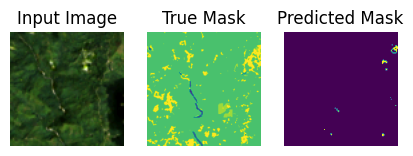

In [239]:
show_predictions(test_ds, 10)

## Conclusion

In this example, we learned how to fine-tune a SegFormer model variant on a custom
dataset for semantic segmentation. In the interest of brevity, the example
was kept short. However, there are a couple of things, you can further try out:

* Incorporate data augmentation to potentially improve the results.
* Use a larger SegFormer model checkpoint to see how the results are affected.
* Push the fine-tuned model to the Hugging Face for sharing with the community easily.
You can do so just by doing `model.push_to_hub("your-username/your-awesome-model")`.
And then you can load the model by doing
`TFSegformerForSemanticSegmentation.from_pretrained("your-username/your-awesome-model"`).
[Here](https://github.com/huggingface/notebooks/blob/main/examples/semantic_segmentation-tf.ipynb)
is an end-to-end example if you're looking for a reference.
* If you'd rather push the model checkpoints to the Hub as the model is being
fine-tuned you can instead use the `PushToHubCallback` Keras callback.
[Here](https://gist.github.com/sayakpaul/f474ffb01f0cdcc8ba239357965c3bca) is an example.
[Here](https://huggingface.co/sayakpaul/mit-b0-finetuned-pets) is an example of a model
repository that was created using this callback.